In [1]:
import os
spark_version = 'spark-3.5.1'
os.environ['SPARK_VERSION']=spark_version

# Install Spark and Java
!apt-get update
!apt-get install openjdk-11-jdk-headless -qq > /dev/null
!wget -q http://www.apache.org/dist/spark/$SPARK_VERSION/$SPARK_VERSION-bin-hadoop3.tgz
!tar xf $SPARK_VERSION-bin-hadoop3.tgz
!pip install -q findspark
!pip install pyspark

# Set Environment Variables
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-11-openjdk-amd64"
os.environ["SPARK_HOME"] = f"/content/{spark_version}-bin-hadoop3"

Get:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,626 B]
Hit:2 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:3 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Get:4 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Hit:5 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:6 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:7 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:8 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Ign:9 https://r2u.stat.illinois.edu/ubuntu jammy InRelease
Hit:10 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Hit:11 https://r2u.stat.illinois.edu/ubuntu jammy Release
Get:12 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  Packages [921 kB]
Get:13 http://security.ubuntu.com/ubuntu jammy-security/restricted amd64 Packages [2,841 kB]

In [2]:
#Import dependencies
import numpy as np
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from pyspark.ml.feature import StringIndexer, OneHotEncoder
from pyspark.ml import Pipeline

# Import Keras Dependencies
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Dense

In [3]:
 # Import findspark and initialize.
import findspark
findspark.init()

In [4]:
 # Start Spark session
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("weatherclassification").getOrCreate()

/usr/lib/python3.10/subprocess.py:1796: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = _posixsubprocess.fork_exec(


In [5]:
# Load in data
from pyspark import SparkFiles
url = 'https://weatherclassification.s3.amazonaws.com/weather_classification_data.csv'
spark.sparkContext.addFile(url)
print(SparkFiles.getRootDirectory())

spark_df = spark.read.csv(SparkFiles.get("weather_classification_data.csv"), sep=",", header=True, inferSchema=True)
spark_df.show()

/tmp/spark-3f82ccaa-88d4-4d4d-a702-59052f677b3a/userFiles-d15ed568-5632-4d17-83d4-426ca3c1c395
+-----------+--------+----------+-----------------+-------------+--------------------+--------+------+---------------+--------+------------+
|Temperature|Humidity|Wind Speed|Precipitation (%)|  Cloud Cover|Atmospheric Pressure|UV Index|Season|Visibility (km)|Location|Weather Type|
+-----------+--------+----------+-----------------+-------------+--------------------+--------+------+---------------+--------+------------+
|         14|      73|       9.5|               82|partly cloudy|             1010.82|       2|Winter|            3.5|  inland|       Rainy|
|         39|      96|       8.5|               71|partly cloudy|             1011.43|       7|Spring|           10.0|  inland|      Cloudy|
|         30|      64|       7.0|               16|        clear|             1018.72|       5|Spring|            5.5|mountain|       Sunny|
|         38|      83|       1.5|               82|        

In [6]:
# Convert PySpark DataFrame to pandas DataFrame
weather_df = spark_df.toPandas()
weather_df.head()

,Temperature,Humidity,Wind Speed,Precipitation (%),Cloud Cover,Atmospheric Pressure,UV Index,Season,Visibility (km),Location,Weather Type
0,14,73,9.5,82,partly cloudy,1010.82,2,Winter,3.5,inland,Rainy
1,39,96,8.5,71,partly cloudy,1011.43,7,Spring,10.0,inland,Cloudy
2,30,64,7.0,16,clear,1018.72,5,Spring,5.5,mountain,Sunny
3,38,83,1.5,82,clear,1026.25,7,Spring,1.0,coastal,Sunny
4,27,74,17.0,66,overcast,990.67,1,Winter,2.5,mountain,Rainy


In [14]:
# Investigate the value counts
weather_df['Weather Type'].value_counts()

,count
Weather Type,
Rainy,3300
Cloudy,3300
Sunny,3300
Snowy,3300


In [8]:
#Create weather data remove Weather Type
weather_data_no_type = weather_df.drop('Weather Type', axis=1)

In [15]:
# Convert categorical data to numeric with `StringIndexer`
weather_data_no_type = pd.get_dummies(weather_data_no_type).astype(int)
weather_data_no_type.head()

,Temperature,Humidity,Wind Speed,Precipitation (%),Atmospheric Pressure,UV Index,Visibility (km),Cloud Cover_clear,Cloud Cover_cloudy,Cloud Cover_overcast,Cloud Cover_partly cloudy,Season_Autumn,Season_Spring,Season_Summer,Season_Winter,Location_coastal,Location_inland,Location_mountain
0,14,73,9,82,1010,2,3,0,0,0,1,0,0,0,1,0,1,0
1,39,96,8,71,1011,7,10,0,0,0,1,0,1,0,0,0,1,0
2,30,64,7,16,1018,5,5,1,0,0,0,0,1,0,0,0,0,1
3,38,83,1,82,1026,7,1,1,0,0,0,0,1,0,0,1,0,0
4,27,74,17,66,990,1,2,0,0,1,0,0,0,0,1,0,0,1


In [16]:
# Split our preprocessed data into our features and target arrays
X = weather_data_no_type
y = weather_df['Weather Type']

# Use LabelEncoder to convert categorical season labels to numerical values
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
num_classes = 4
y_one_hot = to_categorical(y_encoded, num_classes)

encoded_labels = label_encoder.classes_
encoded_labels = label_encoder.transform(label_encoder.classes_)
label_mapping = dict(zip(encoded_labels, label_encoder.classes_))
print(f"Labels: {label_mapping}")

# Split the preprocessed data into a training and testing dataset
X_train, X_test, y_train, y_test = train_test_split(X, y_one_hot, random_state=1)

Labels: {0: 'Cloudy', 1: 'Rainy', 2: 'Snowy', 3: 'Sunny'}


In [17]:
# Investigate Data Shape
print('Data Shapes')
print(f'Training Data: {X_train.shape}')
print(f'Training Labels: {y_train.shape}')
print(f'Training Data: {X_test.shape}')
print(f'Training Labels: {y_test.shape}')

Data Shapes
Training Data: (9900, 18)
Training Labels: (9900, 4)
Training Data: (3300, 18)
Training Labels: (3300, 4)


In [18]:
# Normalize Data
scaler = MinMaxScaler().fit(X_train)

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [19]:
# Create function for model creation
def gen_model(units, activation_functions, input_dim, optimizer):
  # Define the deep learning model
  nn_model = tf.keras.models.Sequential()
  nn_model.add(tf.keras.Input(shape=(input_dim,)))
  for i in range(len(units)):
    nn_model.add(tf.keras.layers.Dense(units=units[i], activation=activation_functions[i]))
  nn_model.add(tf.keras.layers.Dense(units=4, activation="softmax"))

  # Compile the Sequential model together and customize metrics
  nn_model.compile(loss="categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])
  return nn_model

In [ ]:
# Model Optimizer Adam
units = [100, 50, 50, 25]
activations_funcs = ['relu', 'relu', 'relu', 'relu']
nn_model_adam = gen_model(units, activations_funcs, 18, 'adam')


# Train the model
fit_model = nn_model_adam.fit(X_train, y_train, epochs=50)

# Evaluate the model using the test data
nn_model_adam_losses = []
model_loss, model_accuracy = nn_model_adam.evaluate(X_test,y_test,verbose=2)

print(f"Model Optimizer Adam Loss: {model_loss}, Accuracy: {model_accuracy}")


Epoch 1/50
310/310 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.6471 - loss: 0.8920
Epoch 2/50
310/310 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8830 - loss: 0.3879
Epoch 3/50
310/310 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8884 - loss: 0.3338
Epoch 4/50
310/310 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8975 - loss: 0.3006
Epoch 5/50
310/310 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8951 - loss: 0.2947
Epoch 6/50
310/310 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9060 - loss: 0.2690
Epoch 7/50
310/310 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9037 - loss: 0.2721
Epoch 8/50
310/310 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9009 - loss: 0.2701
Epoch 9/50
310/310 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9097 - loss: 0.2451
Epoch 10/50
310/310 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.9097 - loss: 0.2497
Epoch 11/50
310/310 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9116 - loss: 0.2444
Epoch 12/50
310/310 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step

In [ ]:
# Make predictions using testing data
predictions = nn_model_adam.predict(X_test)

# Convert one-hot encoded values to categorical labes
y_test_labels = np.argmax(y_test, axis = 1)

predictions_labels = np.argmax(predictions, axis=1)

# Confusion Matrix
print('Confusion Matrix Model Optimizer Adam')
print(confusion_matrix(y_test_labels, predictions_labels))

# Print the classification report for the model
print("Classification Report Model Optimizer Adam ")
target_names = ["Cloudy", "Rainy", "Snowy", "Sunny"]
print(classification_report(y_test_labels, predictions_labels, target_names=target_names))

104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Confusion Matrix Model Optimizer Adam
[[747  41  27  27]
 [ 45 754  31  16]
 [ 14  39 750  17]
 [ 44  18  20 710]]
Classification Report Model Optimizer Adam 
              precision    recall  f1-score   support

      Cloudy       0.88      0.89      0.88       842
       Rainy       0.88      0.89      0.89       846
       Snowy       0.91      0.91      0.91       820
       Sunny       0.92      0.90      0.91       792

    accuracy                           0.90      3300
   macro avg       0.90      0.90      0.90      3300
weighted avg       0.90      0.90      0.90      3300



In [ ]:
nn_model_adam_losses = fit_model.history['loss']
nn_model_adam_accuracy = fit_model.history['accuracy']

In [ ]:
# Model Optimizers SDG
units = [100, 50, 50, 25]
activations_funcs = ['relu', 'relu', 'relu', 'relu']
nn_model_SDG = gen_model(units, activations_funcs, 18, 'SGD')


# Train the model
fit_model = nn_model_SDG.fit(X_train, y_train, epochs=50)

# Evaluate the model using the test data
model_loss, model_accuracy = nn_model_SDG.evaluate(X_test,y_test,verbose=2)
print(f"# Model Optimizers SDG Loss: {model_loss}, Accuracy: {model_accuracy}")

Epoch 1/50
310/310 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.3026 - loss: 1.3762
Epoch 2/50
310/310 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5761 - loss: 1.1393
Epoch 3/50
310/310 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7753 - loss: 0.7898
Epoch 4/50
310/310 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8289 - loss: 0.5942
Epoch 5/50
310/310 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8394 - loss: 0.5389
Epoch 6/50
310/310 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8435 - loss: 0.5084
Epoch 7/50
310/310 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8602 - loss: 0.4651
Epoch 8/50
310/310 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8655 - loss: 0.4454
Epoch 9/50
310/310 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8670 - loss: 0.4393
Epoch 10/50
310/310 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8778 - loss: 0.4189
Epoch 11/50
310/310 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8831 - loss: 0.4030
Epoch 12/50
310/310 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step

In [ ]:
# Make predictions using testing data
predictions = nn_model_SDG.predict(X_test)

# Convert one-hot encoded values to categorical labes
y_test_labels = np.argmax(y_test, axis = 1)

predictions_labels = np.argmax(predictions, axis=1)

# Confusion Matrix
print('Confusion Matrix # Model Optimizers SDG')
print(confusion_matrix(y_test_labels, predictions_labels))

# Print the classification report for the model
print("Classification Report # Model Optimizers SDG")
target_names = ["Cloudy", "Rainy", "Snowy", "Sunny"]
print(classification_report(y_test_labels, predictions_labels, target_names=target_names))

104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Confusion Matrix # Model Optimizers SDG
[[758  45  23  16]
 [ 62 733  35  16]
 [ 25  19 763  13]
 [ 51  17  13 711]]
Classification Report # Model Optimizers SDG
              precision    recall  f1-score   support

      Cloudy       0.85      0.90      0.87       842
       Rainy       0.90      0.87      0.88       846
       Snowy       0.91      0.93      0.92       820
       Sunny       0.94      0.90      0.92       792

    accuracy                           0.90      3300
   macro avg       0.90      0.90      0.90      3300
weighted avg       0.90      0.90      0.90      3300



In [ ]:
nn_model_SDG_losses = fit_model.history['loss']
nn_model_SDG_accuracy = fit_model.history['accuracy']

In [ ]:
# Model Optimizer Adagrad
units = [200, 100, 100, 50]
activations_funcs = ['relu', 'relu', 'relu', 'relu']
nn_model_adagrad = gen_model(units, activations_funcs, 18, 'Adagrad')


# Train the model
fit_model = nn_model_adagrad.fit(X_train, y_train, epochs=50)

# Evaluate the model using the test data
model_loss, model_accuracy = nn_model_adagrad.evaluate(X_test,y_test,verbose=2)
print(f"Model Optimizer Adagrad Loss: {model_loss}, Accuracy: {model_accuracy}")

Epoch 1/50
310/310 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.3054 - loss: 1.3982
Epoch 2/50
310/310 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.4766 - loss: 1.2933
Epoch 3/50
310/310 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4960 - loss: 1.1799
Epoch 4/50
310/310 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5491 - loss: 1.0698
Epoch 5/50
310/310 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6004 - loss: 0.9839
Epoch 6/50
310/310 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.6442 - loss: 0.8941
Epoch 7/50
310/310 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7071 - loss: 0.8325
Epoch 8/50
310/310 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7466 - loss: 0.7662
Epoch 9/50
310/310 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7747 - loss: 0.7211
Epoch 10/50
310/310 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7929 - loss: 0.6912
Epoch 11/50
310/310 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8182 - loss: 0.6509
Epoch 12/50
310/310 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step

In [ ]:
# Make predictions using testing data
predictions = nn_model_adagrad.predict(X_test)

# Convert one-hot encoded values to categorical labes
y_test_labels = np.argmax(y_test, axis = 1)

predictions_labels = np.argmax(predictions, axis=1)

# Confusion Matrix
print('Confusion Matrix Model Optimizer Adagrad')
print(confusion_matrix(y_test_labels, predictions_labels))

# Print the classification report for the model
print("Classification Report Model Optimizer Adagrad")
target_names = ["Cloudy", "Rainy", "Snowy", "Sunny"]
print(classification_report(y_test_labels, predictions_labels, target_names=target_names))

104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Confusion Matrix Model Optimizer Adagrad
[[740  70  13  19]
 [ 80 658  89  19]
 [ 23  17 759  21]
 [ 56  17  10 709]]
Classification Report Model Optimizer Adagrad
              precision    recall  f1-score   support

      Cloudy       0.82      0.88      0.85       842
       Rainy       0.86      0.78      0.82       846
       Snowy       0.87      0.93      0.90       820
       Sunny       0.92      0.90      0.91       792

    accuracy                           0.87      3300
   macro avg       0.87      0.87      0.87      3300
weighted avg       0.87      0.87      0.87      3300



In [ ]:
nn_model_adagrad_losses = fit_model.history['loss']
nn_model_adagrad_accuracy = fit_model.history['accuracy']

In [ ]:
# Model Optimizer RMSProp
units = [400, 200, 200, 100]
activations_funcs = ['relu', 'relu', 'relu', 'relu']
nn_model_RMSprop = gen_model(units, activations_funcs, 18, 'RMSProp')


# Train the model
fit_model = nn_model_RMSprop.fit(X_train, y_train, epochs=50)

# Evaluate the model using the test data
model_loss, model_accuracy = nn_model_RMSprop.evaluate(X_test,y_test,verbose=2)
print(f"Model Optimizer RMSProp Loss: {model_loss}, Accuracy: {model_accuracy}")

Epoch 1/50
310/310 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.7545 - loss: 0.7131
Epoch 2/50
310/310 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8734 - loss: 0.3857
Epoch 3/50
310/310 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8862 - loss: 0.3390
Epoch 4/50
310/310 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8942 - loss: 0.3140
Epoch 5/50
310/310 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.9014 - loss: 0.2854
Epoch 6/50
310/310 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.8998 - loss: 0.2844
Epoch 7/50
310/310 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.9058 - loss: 0.2630 
Epoch 8/50
310/310 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.9061 - loss: 0.2693
Epoch 9/50
310/310 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9076 - loss: 0.2570
Epoch 10/50
310/310 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.9141 - loss: 0.2489
Epoch 11/50
310/310 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9047 - loss: 0.2542
Epoch 12/50
310/310 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/ste

In [ ]:
# Make predictions using testing data
predictions = nn_model_RMSprop.predict(X_test)

# Convert one-hot encoded values to categorical labes
y_test_labels = np.argmax(y_test, axis = 1)

predictions_labels = np.argmax(predictions, axis=1)

# Confusion Matrix
print('Confusion Matrix Model Optimizer RMSProp')
print(confusion_matrix(y_test_labels, predictions_labels))

# Print the classification report for the model
print("Classification Report Model Optimizer RMSProp")
target_names = ["Cloudy", "Rainy", "Snowy", "Sunny"]
print(classification_report(y_test_labels, predictions_labels, target_names=target_names))

104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Confusion Matrix Model Optimizer RMSProp
[[739  51  25  27]
 [ 30 774  30  12]
 [ 15  23 771  11]
 [ 37  34  12 709]]
Classification Report Model Optimizer RMSProp
              precision    recall  f1-score   support

      Cloudy       0.90      0.88      0.89       842
       Rainy       0.88      0.91      0.90       846
       Snowy       0.92      0.94      0.93       820
       Sunny       0.93      0.90      0.91       792

    accuracy                           0.91      3300
   macro avg       0.91      0.91      0.91      3300
weighted avg       0.91      0.91      0.91      3300



In [ ]:
nn_model_RMSprop_losses = fit_model.history['loss']
nn_model_RMSprop_accuracy = fit_model.history['accuracy']

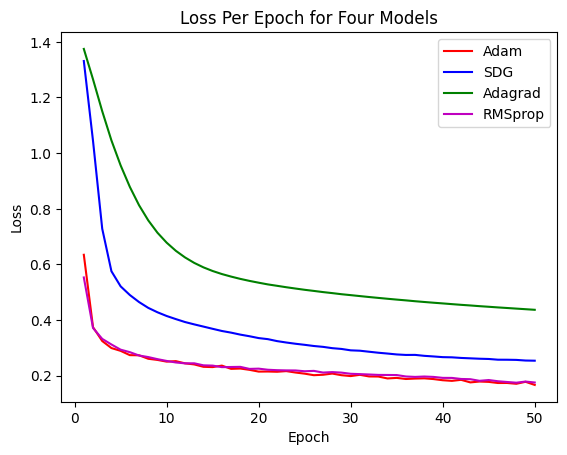

In [ ]:
# Plot losses for each optimizer

epochs = range(1, len(nn_model_adam_losses) + 1)

plt.plot(epochs, nn_model_adam_losses, 'r', label = 'Adam')
plt.plot(epochs, nn_model_SDG_losses, 'b', label = 'SDG')
plt.plot(epochs, nn_model_adagrad_losses, 'g', label = 'Adagrad')
plt.plot(epochs, nn_model_RMSprop_losses, 'm', label = 'RMSprop')

plt.title('Loss Per Epoch for Four Models')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

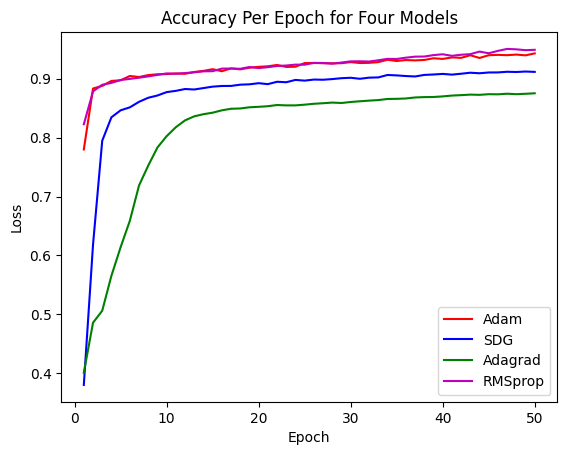

In [ ]:
# Plot accuracy for each optimizer

epochs = range(1, len(nn_model_adam_losses) + 1)

plt.plot(epochs, nn_model_adam_accuracy, 'r', label = 'Adam')
plt.plot(epochs, nn_model_SDG_accuracy, 'b', label = 'SDG')
plt.plot(epochs, nn_model_adagrad_accuracy, 'g', label = 'Adagrad')
plt.plot(epochs, nn_model_RMSprop_accuracy, 'm', label = 'RMSprop')

plt.title('Accuracy Per Epoch for Four Models')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [50]:
# Model Optimizer nn_1
units = [64, 32, 16, 8]
activations_funcs = ['relu', 'relu', 'relu', 'relu']
nn_model_1 = gen_model(units, activations_funcs, 18, 'adam')


# Train the model
fit_model = nn_model_1.fit(X_train, y_train, epochs=50)

# Evaluate the model using the test data
nn_model_1_losses = []
model_loss, model_accuracy = nn_model_1.evaluate(X_test,y_test,verbose=2)

print(f"Model Optimizer Adam Loss: {model_loss}, Accuracy: {model_accuracy}")

Epoch 1/50
310/310 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.6282 - loss: 0.9700
Epoch 2/50
310/310 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8636 - loss: 0.4385
Epoch 3/50
310/310 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8756 - loss: 0.3750
Epoch 4/50
310/310 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8915 - loss: 0.3288
Epoch 5/50
310/310 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8894 - loss: 0.3158
Epoch 6/50
310/310 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8921 - loss: 0.2963
Epoch 7/50
310/310 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8978 - loss: 0.2717
Epoch 8/50
310/310 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9061 - loss: 0.2495
Epoch 9/50
310/310 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8993 - loss: 0.2625
Epoch 10/50
310/310 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9056 - loss: 0.2470
Epoch 11/50
310/310 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9070 - loss: 0.2431
Epoch 12/50
310/310 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step

In [51]:
# Make predictions using testing data
predictions = nn_model_1.predict(X_test)

# Convert one-hot encoded values to categorical labes
y_test_labels = np.argmax(y_test, axis = 1)

predictions_labels = np.argmax(predictions, axis=1)

# Confusion Matrix
print('Confusion Matrix Model Optimizer Adam')
print(confusion_matrix(y_test_labels, predictions_labels))

# Print the classification report for the model
print("Classification Report Model Optimizer Adam ")
target_names = ["Cloudy", "Rainy", "Snowy", "Sunny"]
print(classification_report(y_test_labels, predictions_labels, target_names=target_names))

104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Confusion Matrix Model Optimizer Adam
[[732  49  25  36]
 [ 31 755  37  23]
 [ 16  13 772  19]
 [ 25  14  19 734]]
Classification Report Model Optimizer Adam 
              precision    recall  f1-score   support

      Cloudy       0.91      0.87      0.89       842
       Rainy       0.91      0.89      0.90       846
       Snowy       0.91      0.94      0.92       820
       Sunny       0.90      0.93      0.92       792

    accuracy                           0.91      3300
   macro avg       0.91      0.91      0.91      3300
weighted avg       0.91      0.91      0.91      3300



In [52]:
nn_model_1_losses = fit_model.history['loss']
nn_model_1_accuracy = fit_model.history['accuracy']

In [53]:
# Model Optimizer nn_2
units = [128, 64, 32, 16]
activations_funcs = ['relu', 'relu', 'relu', 'relu']
nn_model_2 = gen_model(units, activations_funcs, 18, 'adam')


# Train the model
fit_model = nn_model_2.fit(X_train, y_train, epochs=50)

# Evaluate the model using the test data
nn_model_2_losses = []
model_loss, model_accuracy = nn_model_2.evaluate(X_test,y_test,verbose=2)

print(f"Model Optimizer Adam Loss: {model_loss}, Accuracy: {model_accuracy}")

Epoch 1/50
310/310 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7154 - loss: 0.8241
Epoch 2/50
310/310 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8732 - loss: 0.3761
Epoch 3/50
310/310 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8785 - loss: 0.3226
Epoch 4/50
310/310 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8915 - loss: 0.2848
Epoch 5/50
310/310 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8978 - loss: 0.2564
Epoch 6/50
310/310 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9007 - loss: 0.2668
Epoch 7/50
310/310 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9030 - loss: 0.2451
Epoch 8/50
310/310 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9094 - loss: 0.2328
Epoch 9/50
310/310 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9120 - loss: 0.2296
Epoch 10/50
310/310 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9083 - loss: 0.2265
Epoch 11/50
310/310 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9136 - loss: 0.2177
Epoch 12/50
310/310 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step

In [54]:
# Make predictions using testing data
predictions = nn_model_2.predict(X_test)

# Convert one-hot encoded values to categorical labes
y_test_labels = np.argmax(y_test, axis = 1)

predictions_labels = np.argmax(predictions, axis=1)

# Confusion Matrix
print('Confusion Matrix Model Optimizer Adam')
print(confusion_matrix(y_test_labels, predictions_labels))

# Print the classification report for the model
print("Classification Report Model Optimizer Adam ")
target_names = ["Cloudy", "Rainy", "Snowy", "Sunny"]
print(classification_report(y_test_labels, predictions_labels, target_names=target_names))

104/104 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Confusion Matrix Model Optimizer Adam
[[731  61  15  35]
 [ 30 774  19  23]
 [ 11  18 771  20]
 [ 31  23  18 720]]
Classification Report Model Optimizer Adam 
              precision    recall  f1-score   support

      Cloudy       0.91      0.87      0.89       842
       Rainy       0.88      0.91      0.90       846
       Snowy       0.94      0.94      0.94       820
       Sunny       0.90      0.91      0.91       792

    accuracy                           0.91      3300
   macro avg       0.91      0.91      0.91      3300
weighted avg       0.91      0.91      0.91      3300



In [55]:
nn_model_2_losses = fit_model.history['loss']
nn_model_2_accuracy = fit_model.history['accuracy']

In [56]:
# Model Optimizer nn_3
units = [256, 128, 64, 32]
activations_funcs = ['relu', 'relu', 'relu', 'relu']
nn_model_3 = gen_model(units, activations_funcs, 18, 'adam')


# Train the model
fit_model = nn_model_3.fit(X_train, y_train, epochs=50)

# Evaluate the model using the test data
nn_model_3_losses = []
model_loss, model_accuracy = nn_model_3.evaluate(X_test,y_test,verbose=2)

print(f"Model Optimizer Adam Loss: {model_loss}, Accuracy: {model_accuracy}")

Epoch 1/50
310/310 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.7463 - loss: 0.7036
Epoch 2/50
310/310 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8851 - loss: 0.3299
Epoch 3/50
310/310 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8991 - loss: 0.2690
Epoch 4/50
310/310 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8985 - loss: 0.2676
Epoch 5/50
310/310 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9013 - loss: 0.2510
Epoch 6/50
310/310 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9060 - loss: 0.2459
Epoch 7/50
310/310 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9121 - loss: 0.2222
Epoch 8/50
310/310 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9133 - loss: 0.2142
Epoch 9/50
310/310 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9097 - loss: 0.2191
Epoch 10/50
310/310 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9134 - loss: 0.2074
Epoch 11/50
310/310 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9190 - loss: 0.1977
Epoch 12/50
310/310 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step

In [57]:
# Make predictions using testing data
predictions = nn_model_3.predict(X_test)

# Convert one-hot encoded values to categorical labes
y_test_labels = np.argmax(y_test, axis = 1)

predictions_labels = np.argmax(predictions, axis=1)

# Confusion Matrix
print('Confusion Matrix Model Optimizer Adam')
print(confusion_matrix(y_test_labels, predictions_labels))

# Print the classification report for the model
print("Classification Report Model Optimizer Adam ")
target_names = ["Cloudy", "Rainy", "Snowy", "Sunny"]
print(classification_report(y_test_labels, predictions_labels, target_names=target_names))

104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Confusion Matrix Model Optimizer Adam
[[738  53  22  29]
 [ 43 750  33  20]
 [ 18  11 768  23]
 [ 35  15  17 725]]
Classification Report Model Optimizer Adam 
              precision    recall  f1-score   support

      Cloudy       0.88      0.88      0.88       842
       Rainy       0.90      0.89      0.90       846
       Snowy       0.91      0.94      0.93       820
       Sunny       0.91      0.92      0.91       792

    accuracy                           0.90      3300
   macro avg       0.90      0.90      0.90      3300
weighted avg       0.90      0.90      0.90      3300



In [58]:
nn_model_3_losses = fit_model.history['loss']
nn_model_3_accuracy = fit_model.history['accuracy']

In [59]:
# Model Optimizer nn_4
units = [32, 64, 128, 256]
activations_funcs = ['relu', 'relu', 'relu', 'relu']
nn_model_4 = gen_model(units, activations_funcs, 18, 'adam')


# Train the model
fit_model = nn_model_4.fit(X_train, y_train, epochs=50)

# Evaluate the model using the test data
nn_model_4_losses = []
model_loss, model_accuracy = nn_model_4.evaluate(X_test,y_test,verbose=2)

print(f"Model Optimizer Adam Loss: {model_loss}, Accuracy: {model_accuracy}")

Epoch 1/50
310/310 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.6930 - loss: 0.8218
Epoch 2/50
310/310 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8788 - loss: 0.3743
Epoch 3/50
310/310 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8982 - loss: 0.2942
Epoch 4/50
310/310 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8922 - loss: 0.2849
Epoch 5/50
310/310 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8931 - loss: 0.2715
Epoch 6/50
310/310 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9028 - loss: 0.2465
Epoch 7/50
310/310 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8992 - loss: 0.2477
Epoch 8/50
310/310 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9026 - loss: 0.2393
Epoch 9/50
310/310 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9086 - loss: 0.2349
Epoch 10/50
310/310 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9116 - loss: 0.2123
Epoch 11/50
310/310 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9127 - loss: 0.2134
Epoch 12/50
310/310 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step

In [60]:
# Make predictions using testing data
predictions = nn_model_4.predict(X_test)

# Convert one-hot encoded values to categorical labes
y_test_labels = np.argmax(y_test, axis = 1)

predictions_labels = np.argmax(predictions, axis=1)

# Confusion Matrix
print('Confusion Matrix Model Optimizer Adam')
print(confusion_matrix(y_test_labels, predictions_labels))

# Print the classification report for the model
print("Classification Report Model Optimizer Adam ")
target_names = ["Cloudy", "Rainy", "Snowy", "Sunny"]
print(classification_report(y_test_labels, predictions_labels, target_names=target_names))

104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Confusion Matrix Model Optimizer Adam
[[739  46  26  31]
 [ 44 744  30  28]
 [ 15  12 780  13]
 [ 41  22  23 706]]
Classification Report Model Optimizer Adam 
              precision    recall  f1-score   support

      Cloudy       0.88      0.88      0.88       842
       Rainy       0.90      0.88      0.89       846
       Snowy       0.91      0.95      0.93       820
       Sunny       0.91      0.89      0.90       792

    accuracy                           0.90      3300
   macro avg       0.90      0.90      0.90      3300
weighted avg       0.90      0.90      0.90      3300



In [61]:
nn_model_4_losses = fit_model.history['loss']
nn_model_4_accuracy = fit_model.history['accuracy']

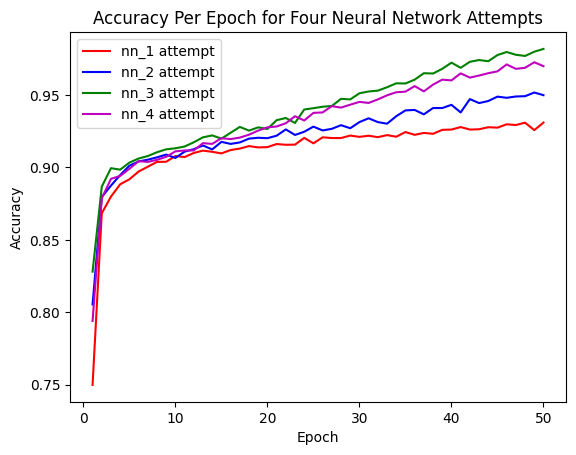

In [68]:
# Plot losses for each neural network attempts

epochs = range(1, len(nn_model_1_accuracy) + 1)

plt.plot(epochs, nn_model_1_accuracy, 'r', label = 'nn_1 attempt')
plt.plot(epochs, nn_model_2_accuracy, 'b', label = 'nn_2 attempt')
plt.plot(epochs, nn_model_3_accuracy, 'g', label = 'nn_3 attempt')
plt.plot(epochs, nn_model_4_accuracy, 'm', label = 'nn_4 attempt')

plt.title('Accuracy Per Epoch for Four Neural Network Attempts')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
# Plot accuracy for each neural network attempts

epochs = range(1, len(nn_model_adam_losses) + 1)

plt.plot(epochs, nn_model_adam_accuracy, 'r', label = 'Adam')
plt.plot(epochs, nn_model_SDG_accuracy, 'b', label = 'SDG')
plt.plot(epochs, nn_model_adagrad_accuracy, 'g', label = 'Adagrad')
plt.plot(epochs, nn_model_RMSprop_accuracy, 'm', label = 'RMSprop')

plt.title('Accuracy Per Epoch for Four Models')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()